 # Comparison of PCN and BioPCN on MNIST with a single large hidden (linear) layer

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch
import time

from cpcn import *
from cpcn.graph import *

 ## Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# get train, validation, and test loaders for MNIST
dataset = load_mnist(n_validation=500, device=device)

 ## Train PCN

In [3]:
n_batches = 2000
dims = [784, 600, 10]
z_it = 50
z_lr = 0.07
rho = 1.0
# rho = 0.0012

t0 = time.time()
torch.manual_seed(123)

net0 = PCNetwork(
    dims,
    activation=lambda _: _,
    z_lr=z_lr,
    z_it=z_it,
    variances=1.0,
    # constrained=True,
    constrained=False,
    rho=rho,
    bias=False,
)

net = PCWrapper(net0, "linear").to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
trainer = Trainer(dataset["train"])
trainer.metrics["accuracy"] = one_hot_accuracy
for batch in tqdmw(trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(net)

    ns = batch.feed(net)
    optimizer.step()

results = trainer.history
print(f"Training PCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Training PCN took 70.0 seconds.


 ### Show PCN learning curves

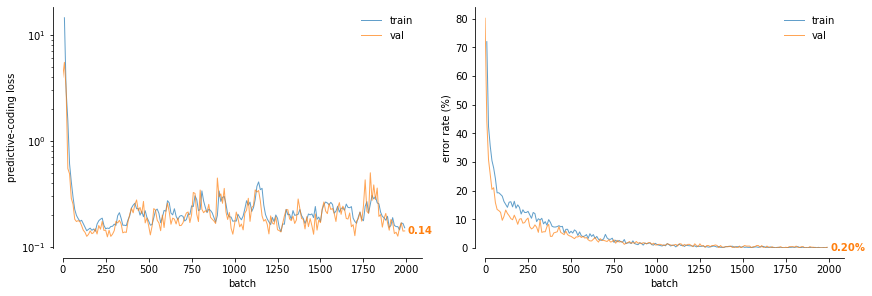

In [4]:
_ = show_learning_curves(results)

 ## Train BioPCN

In [5]:
z_it = 50
z_lr = 0.02
Q_lr_factor = 5

t0 = time.time()
torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net0 = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)

biopcn_net = PCWrapper(biopcn_net0, "linear").to(device)
biopcn_optimizer = multi_lr(
    torch.optim.SGD,
    biopcn_net.parameter_groups(),
    lr_factors={"Q": Q_lr_factor},
    lr=0.003,
)
biopcn_trainer = Trainer(dataset["train"])
biopcn_trainer.metrics = trainer.metrics
for batch in tqdmw(biopcn_trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(biopcn_net)

    ns = batch.feed(biopcn_net)
    biopcn_optimizer.step()

biopcn_results = biopcn_trainer.history
print(f"Training BioPCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Training BioPCN took 103.7 seconds.


 ### Show BioPCN learning curves

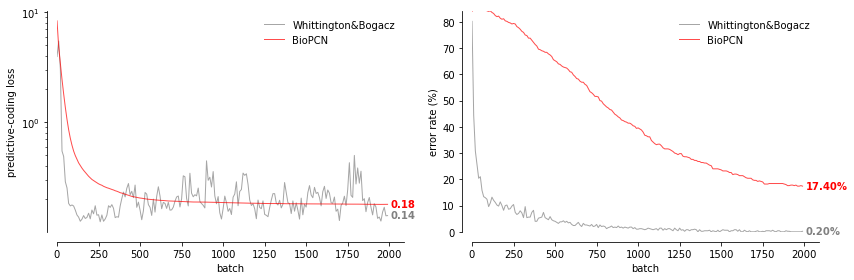

In [6]:
with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        axs=axs,
    )

In [7]:
net

PCWrapper(pc_net=PCNetwork(dims=array([784, 600,  10]), activation=[<function <lambda> at 0x7ff699ce7790>, <function <lambda> at 0x7ff699ce7790>], bias=False, constrained=False, z_it=50, z_lr=0.07, variances=[1. 1.]), predictor=Linear(in_features=600, out_features=10, bias=True), dim=-2, loss=MSELoss())

In [8]:
biopcn_net

PCWrapper(pc_net=LinearBioPCN(dims=array([784, 600,  10]), inter_dims=array([600]), bias_a=False, bias_b=False, fast_optimizer=<class 'torch.optim.adam.Adam'>, z_it=50, z_lr=0.02, g_a=array([1.]), g_b=array([1.]), l_s=array([1.]), c_m=tensor([0.]), rho=tensor([1.]) ), predictor=Linear(in_features=600, out_features=10, bias=True), dim=-2, loss=MSELoss())

In [9]:
z_it = 50
z_lr = 0.02
Q_lr_factor = 5

t0 = time.time()
torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net0 = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)

biopcn_net = PCWrapper(biopcn_net0, "linear").to(device)
biopcn_optimizer = multi_lr(
    torch.optim.SGD,
    biopcn_net.pcn.parameter_groups(),
    lr_factors={"Q": Q_lr_factor},
    lr=0.003,
)
biopcn_predictor_optimizer = torch.optim.Adam(biopcn_net.predictor.parameters())
biopcn_trainer = Trainer(dataset["train"])
biopcn_trainer.metrics = trainer.metrics
for batch in tqdmw(biopcn_trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(biopcn_net)

    ns = batch.feed(biopcn_net)
    biopcn_optimizer.step()
    biopcn_predictor_optimizer.step()

biopcn_results = biopcn_trainer.history
print(f"Training BioPCN took {time.time() - t0:.1f} seconds.")

AttributeError: 'PCWrapper' object has no attribute 'pcn'

In [10]:
z_it = 50
z_lr = 0.02
Q_lr_factor = 5

t0 = time.time()
torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net0 = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)

biopcn_net = PCWrapper(biopcn_net0, "linear").to(device)
biopcn_optimizer = multi_lr(
    torch.optim.SGD,
    biopcn_net.pcn_net.parameter_groups(),
    lr_factors={"Q": Q_lr_factor},
    lr=0.003,
)
biopcn_predictor_optimizer = torch.optim.Adam(biopcn_net.predictor.parameters())
biopcn_trainer = Trainer(dataset["train"])
biopcn_trainer.metrics = trainer.metrics
for batch in tqdmw(biopcn_trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(biopcn_net)

    ns = batch.feed(biopcn_net)
    biopcn_optimizer.step()
    biopcn_predictor_optimizer.step()

biopcn_results = biopcn_trainer.history
print(f"Training BioPCN took {time.time() - t0:.1f} seconds.")

AttributeError: 'PCWrapper' object has no attribute 'pcn_net'

In [11]:
biopcn_net

PCWrapper(pc_net=LinearBioPCN(dims=array([784, 600,  10]), inter_dims=array([600]), bias_a=False, bias_b=False, fast_optimizer=<class 'torch.optim.adam.Adam'>, z_it=50, z_lr=0.02, g_a=array([1.]), g_b=array([1.]), l_s=array([1.]), c_m=tensor([0.]), rho=tensor([1.]) ), predictor=Linear(in_features=600, out_features=10, bias=True), dim=-2, loss=MSELoss())

In [12]:
z_it = 50
z_lr = 0.02
Q_lr_factor = 5

t0 = time.time()
torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net0 = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)

biopcn_net = PCWrapper(biopcn_net0, "linear").to(device)
biopcn_optimizer = multi_lr(
    torch.optim.SGD,
    biopcn_net.pc_net.parameter_groups(),
    lr_factors={"Q": Q_lr_factor},
    lr=0.003,
)
biopcn_predictor_optimizer = torch.optim.Adam(biopcn_net.predictor.parameters())
biopcn_trainer = Trainer(dataset["train"])
biopcn_trainer.metrics = trainer.metrics
for batch in tqdmw(biopcn_trainer(n_batches)):
    if batch.every(10):
        batch.evaluate(dataset["validation"]).run(biopcn_net)

    ns = batch.feed(biopcn_net)
    biopcn_optimizer.step()
    biopcn_predictor_optimizer.step()

biopcn_results = biopcn_trainer.history
print(f"Training BioPCN took {time.time() - t0:.1f} seconds.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Training BioPCN took 104.1 seconds.


 ### Show BioPCN learning curves

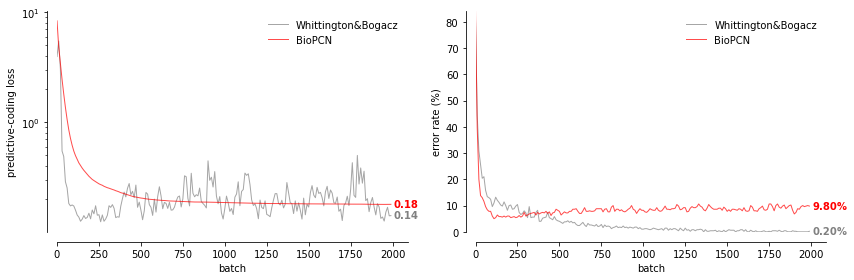

In [13]:
with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        axs=axs,
    )